# Exploration: opening prices of S&P 500 constituents around COVID-19 outbreak 

We expect different companies to incorporate information from global shocks at different speeds. This notebook tries to recover clusters of companies whose share prices responded to COVID-19 similarly by looking at their opening prices on the S&P 500 over the last 150 days (from the time the notebook is run). Four measures of time series similarity are used to create clusters. See previous notebooks for measures (3,4, and 5).

1. Instantaneous correlation of log-returns. 
2. Mean shift similarity. 
3. Frechet distance between piecewise-constant skeletons. 
4. Frechet distance between piecewise-linear skeletons. 

## Setup 

Load scrips and packages, read in data. 

In [2]:
source("../scripts/build_datasets.R")
source("../scripts/frechet_dist_skeleton.R")
source("../scripts/mean_shift_similarity.R")
source("../scripts/cluster_process.R")

Warning message:
"Columns [Founded] seem to have no data and are removed. Use rm_nodata_cols = F to suppress this behavior"


In [ ]:
SnP500 <- SnP500.data(Sys.Date()-150,Sys.Date(),quiet = TRUE)
SnP.returns <- apply(SnP500,2, function(x) diff(log(x)))

### EDA

Plotting opening prices and log-returns for the entire panel and a random sample of 50 time series it is clear that most stock prices responded similarly to COVID-19 - still, there is clear heterogeneity in the panel. Importantly, time series which are spatially remote may have responded to the COVID-19 shock in ways which are (loosely speaking) geometrically similar. 

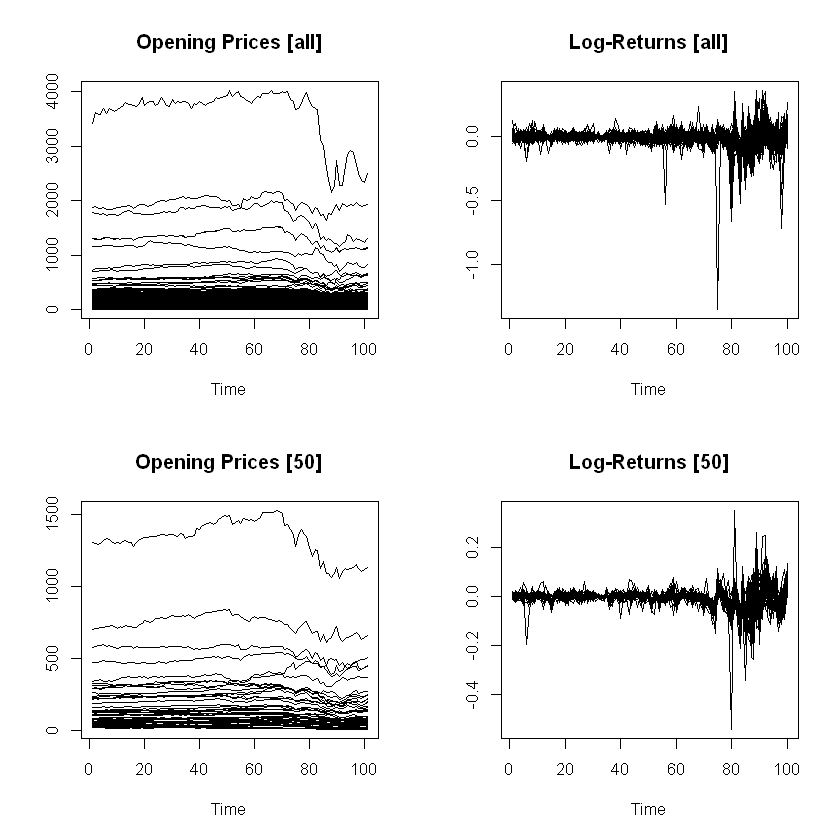

In [84]:
par(mfrow = c(2,2))
ts.plot(SnP500, main = "Opening Prices [all]");ts.plot(SnP.returns, main = "Log-Returns [all]")
ts.plot(SnP500[,sample(1:500,50)], main = "Opening Prices [50]");ts.plot(SnP.returns[,sample(1:500,50)], main = "Log-Returns [50]")

## Instantaneous correlation of log-returns

Below a dendrogram is built the instantaneous correlation. I choose to cut the tree at `h=0.2`; this choise is not at all rigorous, however choosing different values for `h` does not change the discussion below. 

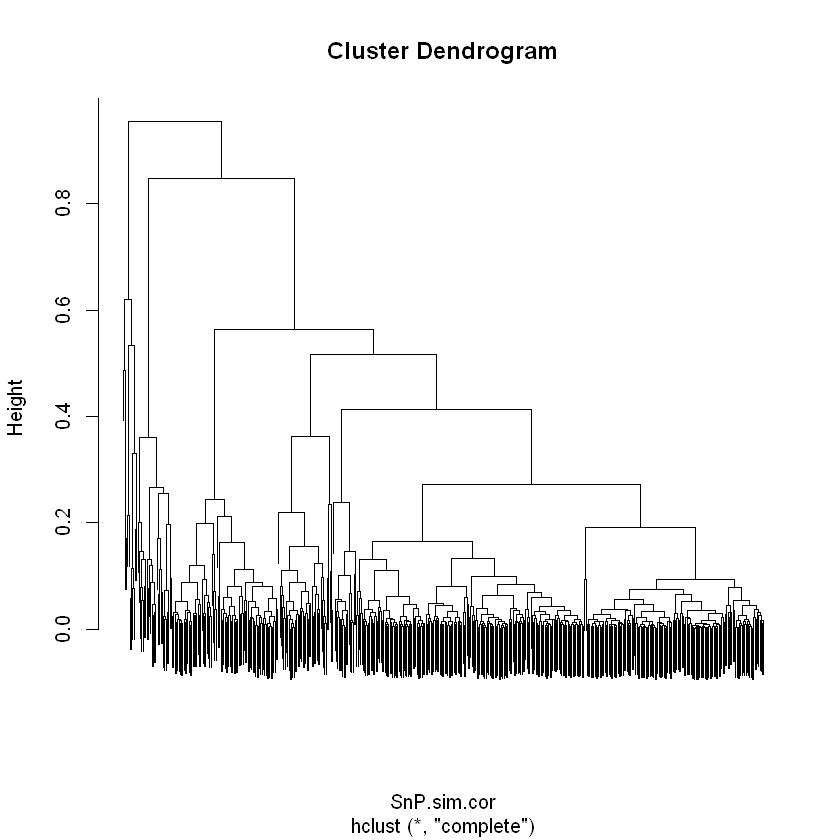

In [62]:
SnP.cor.sim <- as.dist((1-cor(SnP500))/2)
SnP.cor.hc <- hclust(SnP.sim.cor)
plot(SnP.cor.hc, labels = FALSE)

### Sector similarity within clusters

Clusters do not seem to be composed of companies from similar sectors or sub industries. This is not surprising as the shock in question is extremely widespread. 

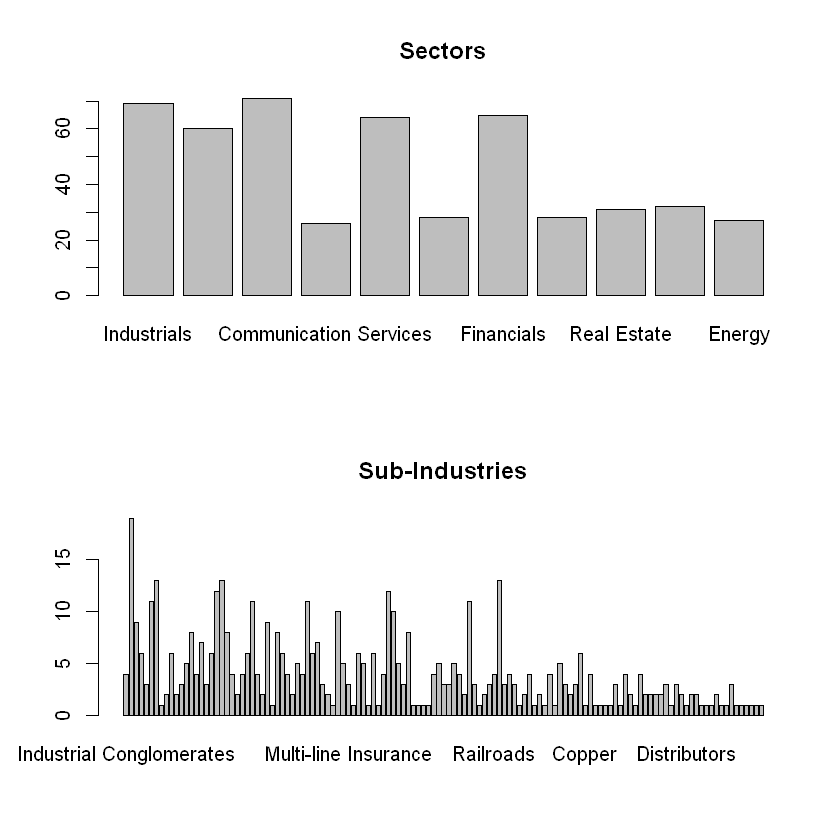

In [115]:
SnP.cor.clusters <- ticker.cluster.info(SnP.cor.hc, h = 0.2, SnP500.info = SnP500.info)
ticker.cluster.boxplot(subset(SnP.cor.clusters$cluster.info, subsets = sample(1:10,1)))

(A table of membership counts for clusters)

In [112]:
t(SnP.cor.clusters$cluster.counts)

cluster,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
count,141,37,47,178,6,8,17,35,7,3,...,2,1,4,2,1,1,1,2,1,1


### Visual similarity within clusters

Clustering on correlations does uncover groups of time series which are visually similar (left) and so can be said to have reacted to the shock in similar ways. However, the method does return some clusters in which time series are neither geometrically similar nor spatially close (right).

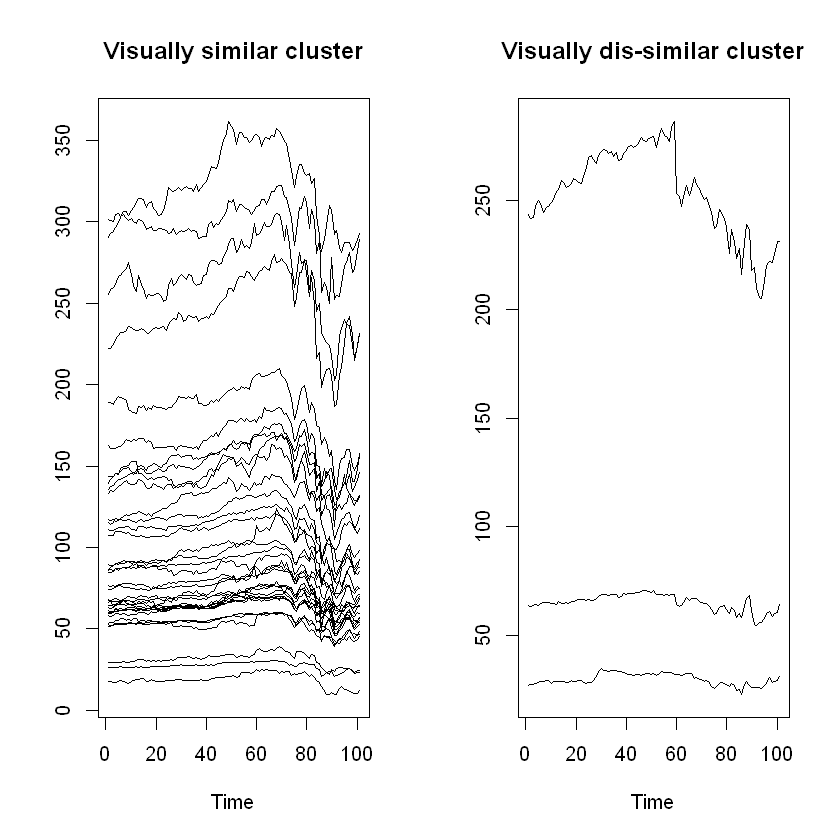

In [122]:
par(mfrow = c(1,2))
cluster.names <- names(subset(SnP.cor.clusters$cluster.info, clusters == 8)$Symbol)
ts.plot(subset(SnP500, select = cluster.names), main = "Visually similar cluster")
cluster.names <- names(subset(SnP.cor.clusters$cluster.info, clusters == 10)$Symbol)
ts.plot(subset(SnP500, select = cluster.names), main = "Visually dis-similar cluster")

## Mean shift similarity

Below is an attempt at grouping time series by looking for evidence of a single mean shift via a vanilla CUSUM statistic. 

The histogram of maximum values for the CUSUM statistic of each time series is unimodal and so can be used only to split the panel into at most two groups. Additionally, plotting the CUSUM statistic for each time series in the panel it es clear the if there is a mean shift it occurs at roughly the same time for every series in the panel.

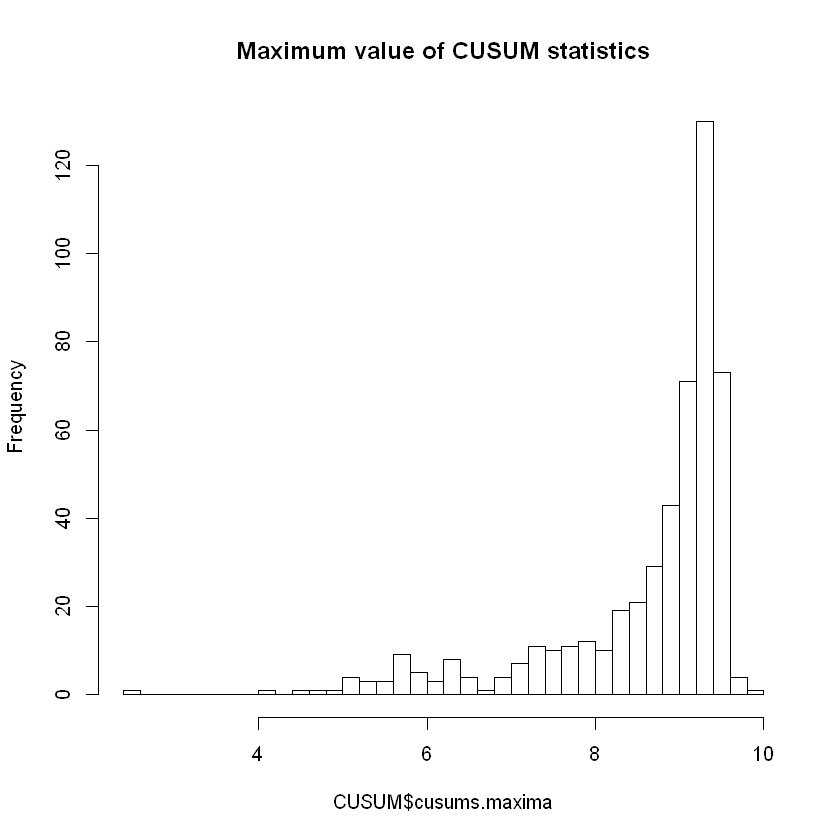

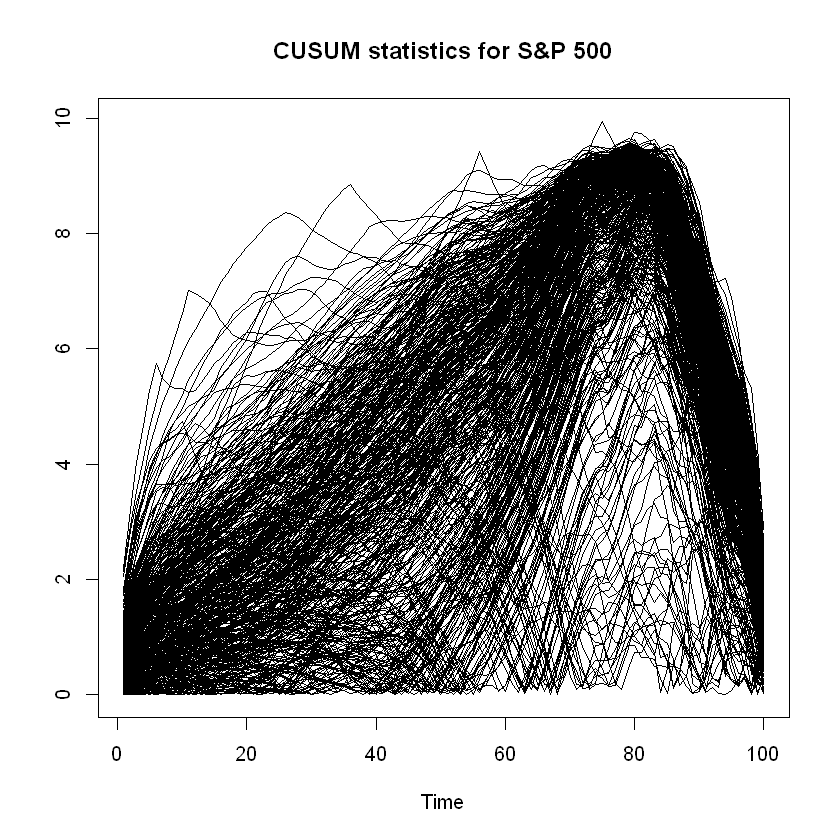

In [232]:
CUSUM <- cusum.locs(SnP500)
hist(CUSUM$cusums.maxima, 50, main = "Maximum value of CUSUM statistics")
ts.plot(CUSUM$cusums, main = "CUSUM statistics for S&P 500")

### An attempt at extracting meaningful groups

The histogram of CUSUM statistics seems to peak around 9. There are 279 series which meet or exceed this threshold. Extracting time series around the peak of the histogram (say with maximum statistics between 9 and 9.1) does reveal visually similar time series, however these time series are very similar to this with CUSUM maxima far from the peak. 

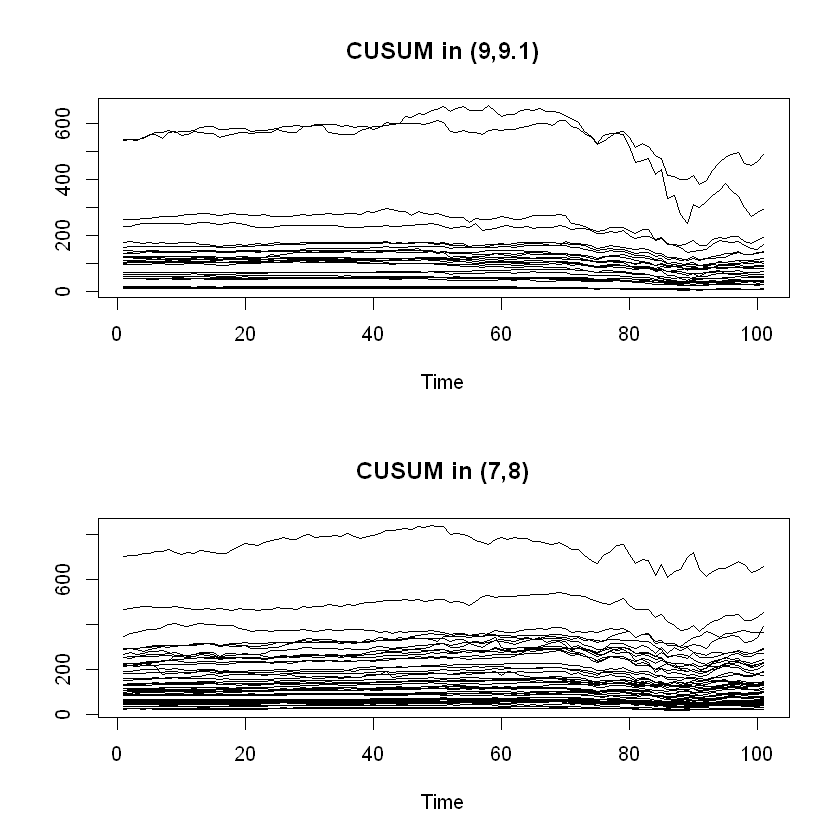

In [231]:
par(mfrow = c(2,1))
ts.plot(SnP500[,which(CUSUM$cusums.maxima > 9 & CUSUM$cusums.maxima < 9.1)], main = "CUSUM in (9,9.1)")
ts.plot(SnP500[,which(CUSUM$cusums.maxima > 7 & CUSUM$cusums.maxima < 8)], main = "CUSUM in (7,8)")

## Piecewise-constant skeleton

A densrogram built on the Frechet distances between piecewise constant approximations of each time series in the panel. The good place to cut the tree seems to be `h = 0.6`.

[1] "fitting time series skeletons (in parallel)"
[1] "calculating distance matrix..."


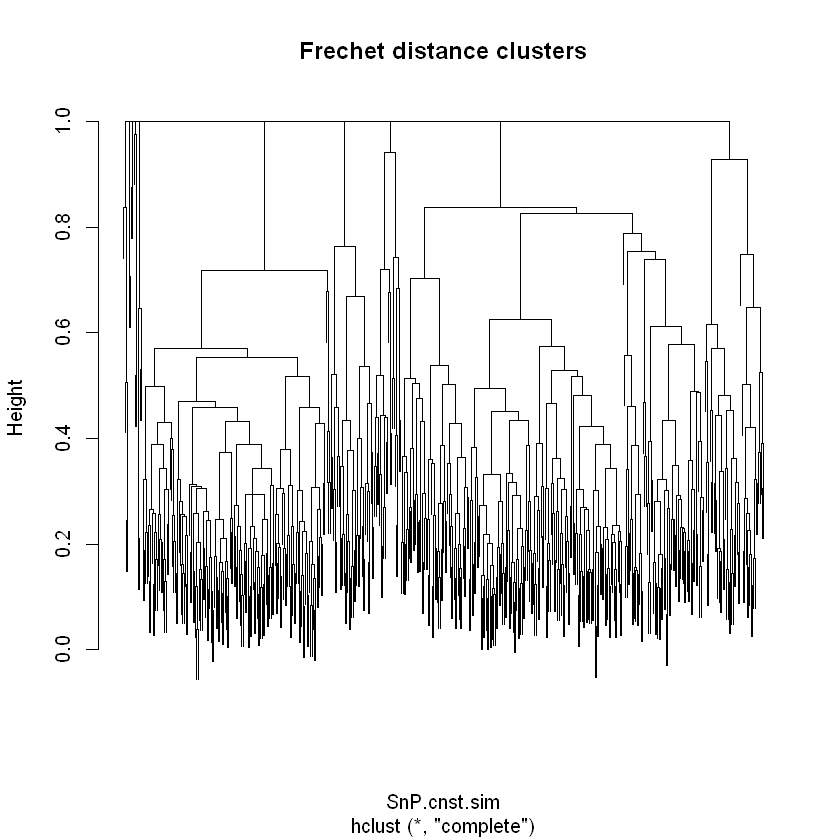

In [129]:
SnP.cnst.sim <- skeleton.similarity(SnP500, set.contrast = "pcwsConstMean", parallel.comp = TRUE)
SnP.cnst.hc <- hclust(SnP.cnst.sim)
plot(SnP.cnst.hc, main = "Frechet distance clusters", labels = FALSE)

### Sector similarity within clusters

As discussed above clusters do not companies from the same sector or industry.

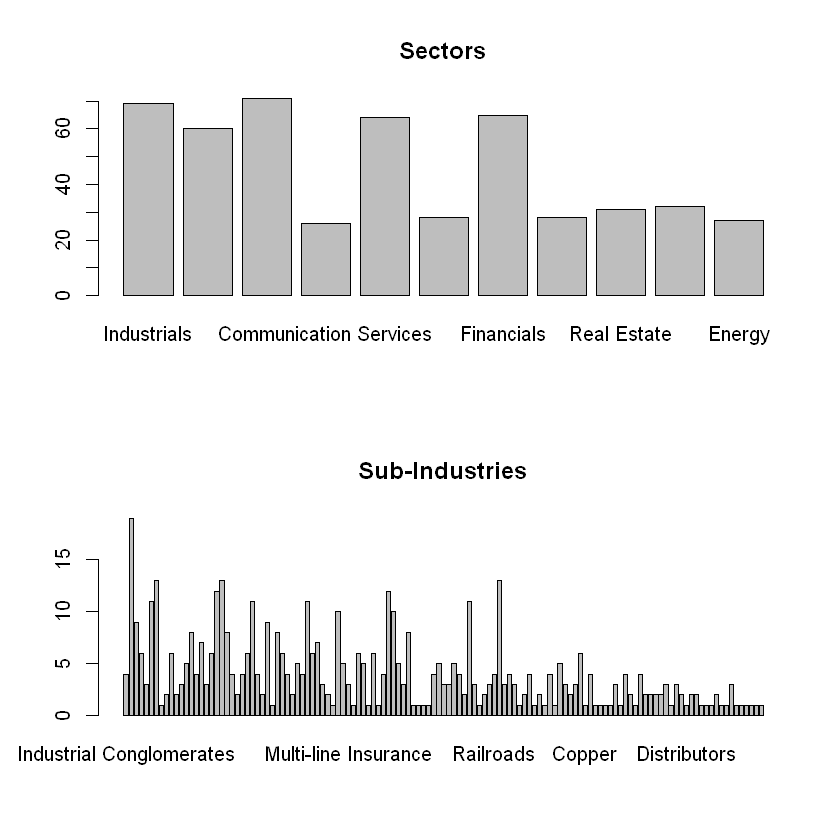

In [142]:
SnP.cnst.clusters <- ticker.cluster.info(SnP.cnst.hc, h = 0.6, SnP500.info = SnP500.info)
ticker.cluster.boxplot(subset(SnP.cnst.clusters$cluster.info, subsets = sample(1:10,1)))

(A table of membership counts for clusters)

In [165]:
t(SnP.cnst.clusters$cluster.counts)

cluster,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
count,24,4,40,5,70,11,7,33,50,143,...,2,1,1,2,2,1,2,1,1,1


### Visual similarity within clusters

Within each clusters time series are visualy similar, and I could not find clusters with visually dis-similar time-series. 

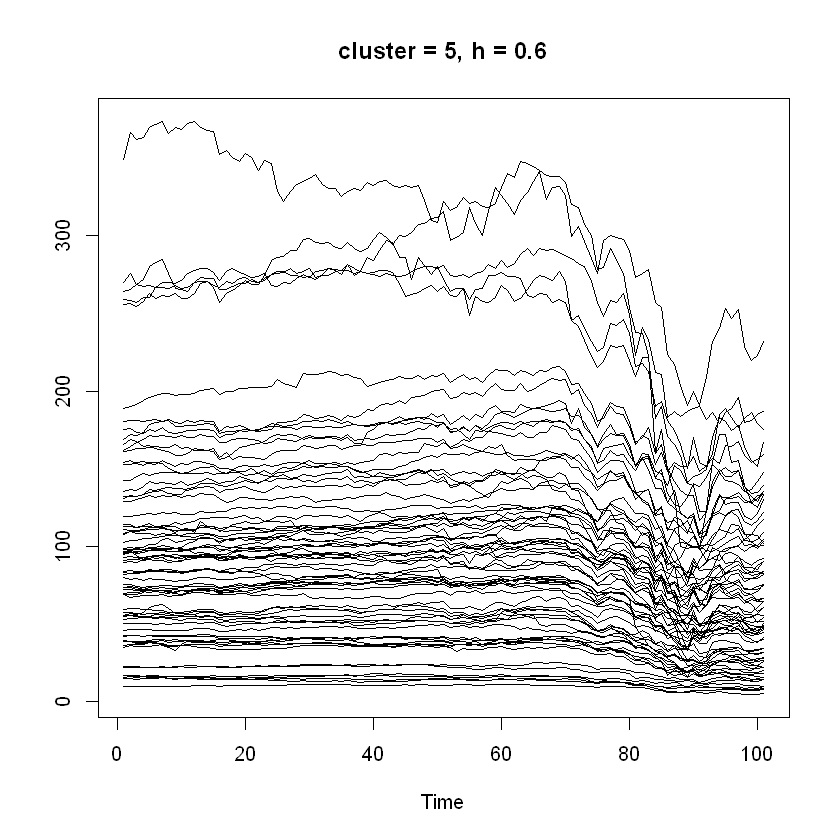

In [170]:
cluster.names <- names(subset(SnP.cnst.clusters$cluster.info, clusters == 5)$Symbol)
ts.plot(subset(SnP500, select = cluster.names), main = "cluster = 5, h = 0.6")

Some clusters contain only a handful of time series, when these clusters are plotted the visual similarity is striking. A large number of clusters contain only one time series, which is potentially problematic. 

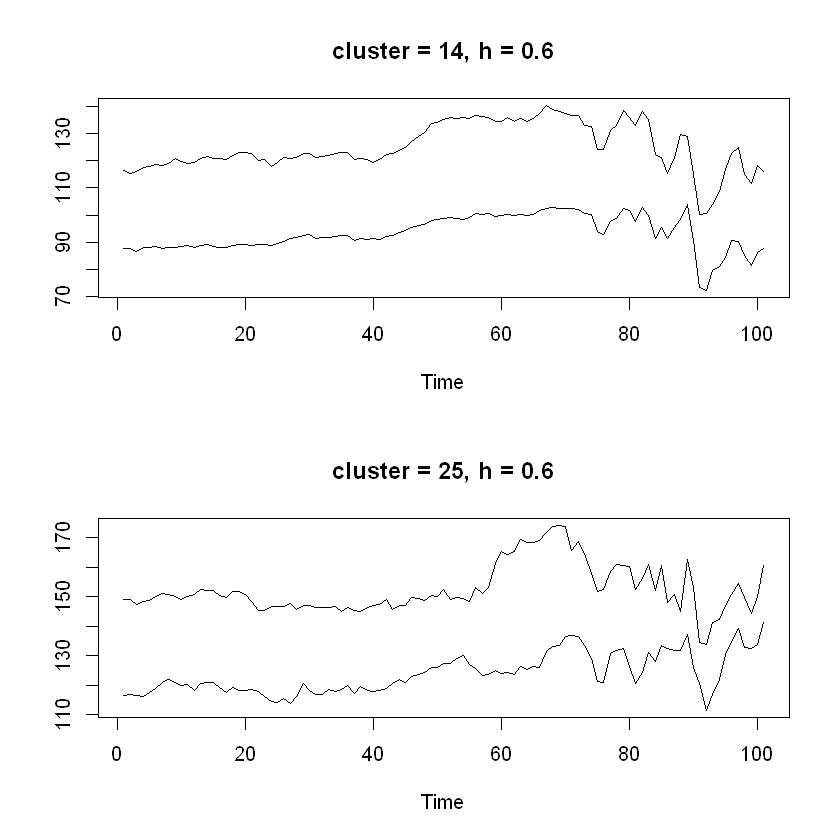

In [166]:
par(mfrow = c(2,1))
cluster.names <- names(subset(SnP.cnst.clusters$cluster.info, clusters == 14)$Symbol)
ts.plot(subset(SnP500, select = cluster.names), main = "cluster = 14, h = 0.6")
cluster.names <- names(subset(SnP.cnst.clusters$cluster.info, clusters == 25)$Symbol)
ts.plot(subset(SnP500, select = cluster.names), main = "cluster = 25, h = 0.6")

## Piecewise-linear skeleton

A dendrogram built on the Frechet distances between piecewise linear approximations. As with in the piecewise constant case the tree will be cut at `h=0.6`.

[1] "fitting time series skeletons (in parallel)"
[1] "calculating distance matrix..."


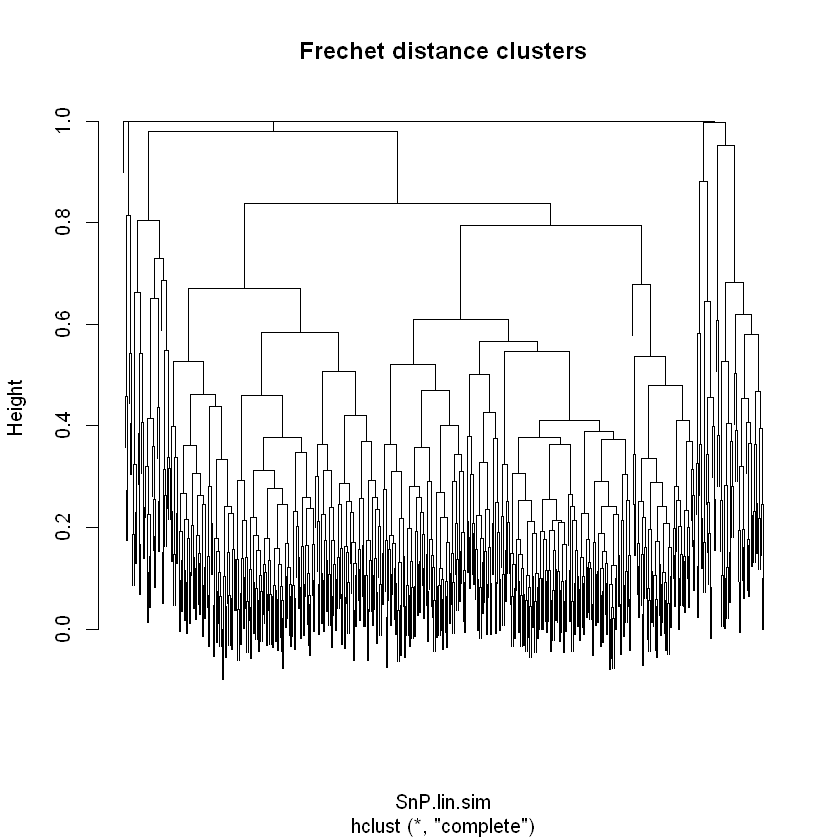

In [171]:
SnP.lin.sim <- skeleton.similarity(SnP500, set.contrast = "pcwsLinMean", parallel.comp = TRUE)
SnP.lin.hc <- hclust(SnP.lin.sim)
plot(SnP.lin.hc, main = "Frechet distance clusters", labels = FALSE)

### Sector similarity within clusters

Same as above. 

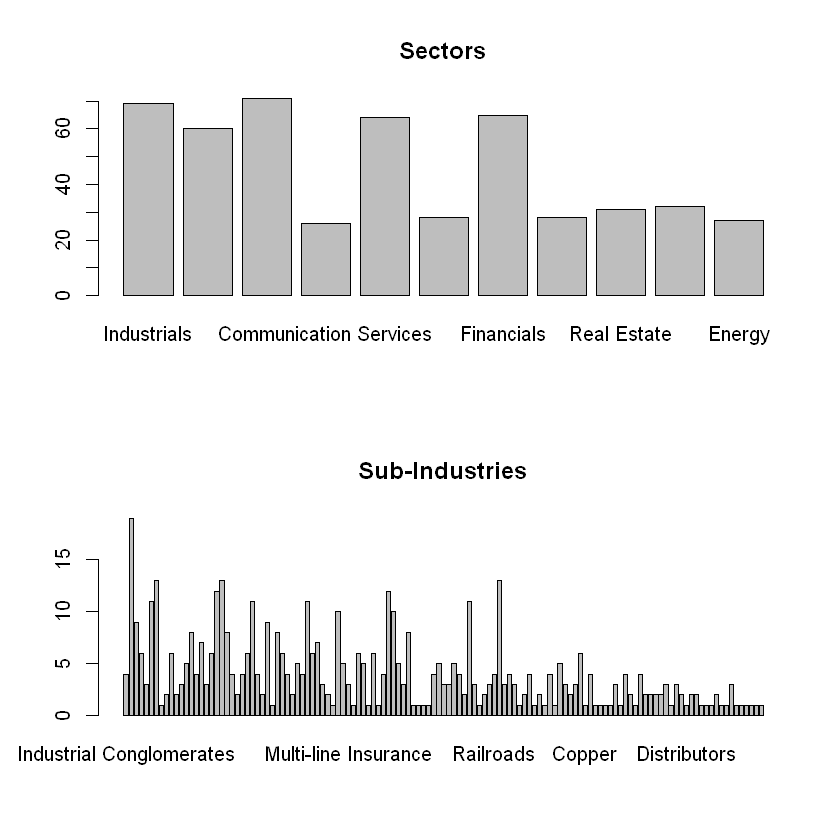

In [172]:
SnP.lin.clusters <- ticker.cluster.info(SnP.lin.hc, h = 0.6, SnP500.info = SnP500.info)
ticker.cluster.boxplot(subset(SnP.lin.clusters$cluster.info, subsets = sample(1:10,1)))

### Number of clusters

Fitting a piecewise linear skeleton tends to give fewer clusters overall and fewer clusters containing only a handful of time series (for similar choices of `h`). This is likely because ...  A table of membership membership counts for each cluster is shown below. 

In [173]:
t(SnP.lin.clusters$cluster.counts)

cluster,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
count,49,66,7,2,9,11,21,114,129,51,...,3,6,6,3,3,3,1,2,1,1


### Visual similarity within clusters

Almost every cluster is a grouping of visually similar time series. 

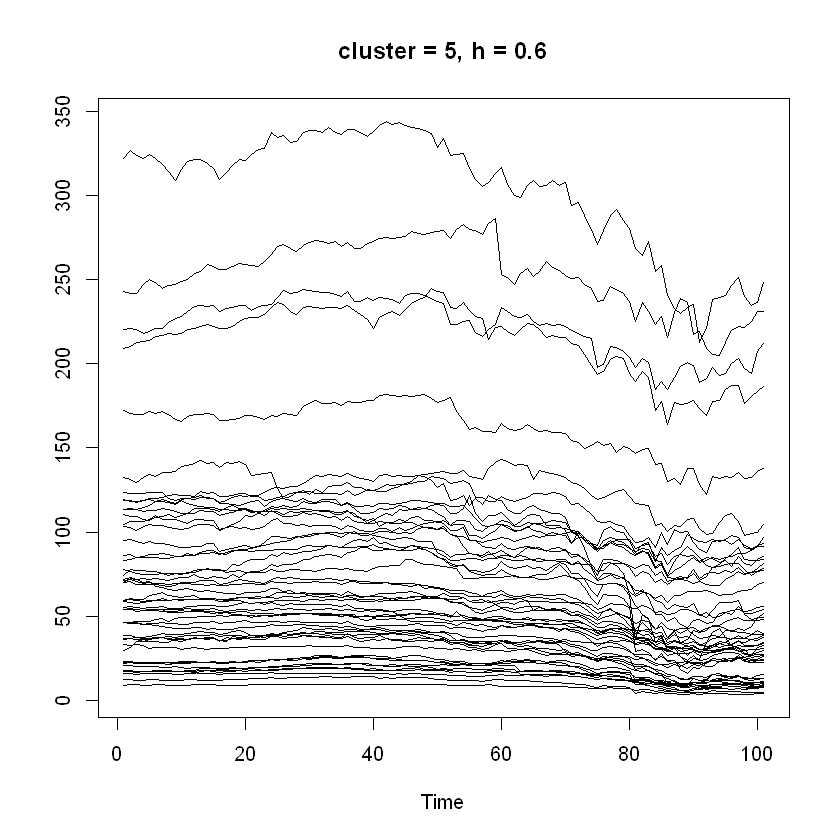

In [196]:
cluster.names <- names(subset(SnP.lin.clusters$cluster.info, clusters == 1)$Symbol)
ts.plot(subset(SnP500, select = cluster.names), main = "cluster = 5, h = 0.6")

With `h=0.6` the only exception is the following: 

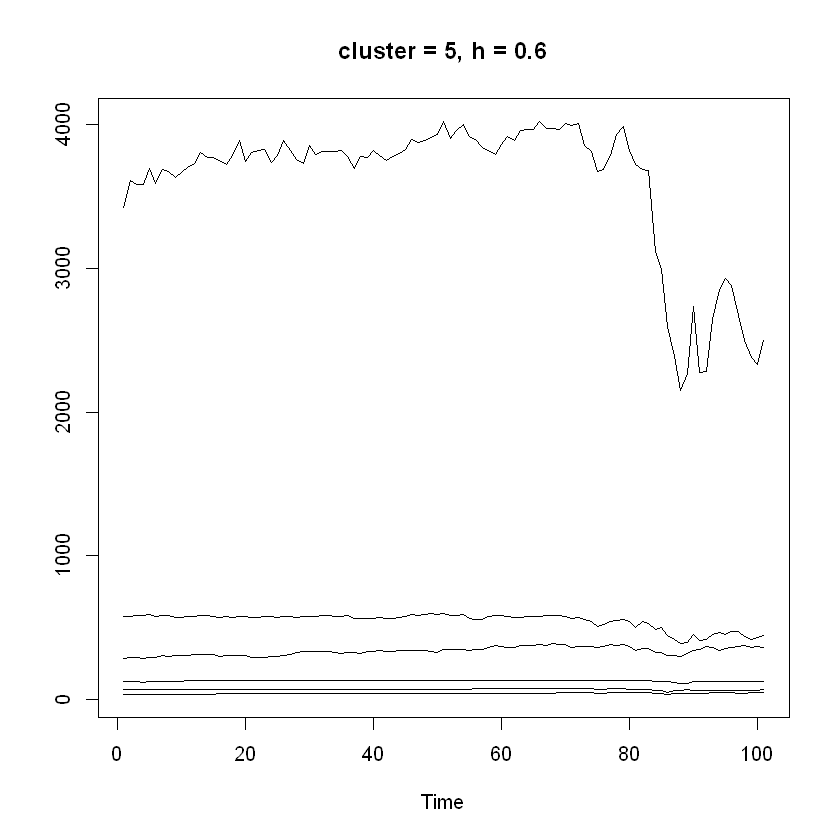

In [194]:
cluster.names <- names(subset(SnP.lin.clusters$cluster.info, clusters == 16)$Symbol)
ts.plot(subset(SnP500, select = cluster.names), main = "cluster = 5, h = 0.6")